# Preamble

In [1]:
import numpy as np
import spinmob as s

In [2]:
from sympy import sympify
from scipy.optimize import minimize

Load in data (1=rigel, 2=joseph, 3=miles) and convert inches to cm:

In [5]:
datafilenames = ["calibration_data"+str(i)+".csv" for i in range(1, 4)]
calibration_datas = [s.data.load(datafilename) for datafilename in datafilenames]
added_voltage_error = 0#0.05
inch_to_cm = 2.54
for calibration_data in calibration_datas:
    calibration_data[0] *= inch_to_cm
    calibration_data[2] *= inch_to_cm
    calibration_data[3] += added_voltage_error

Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: measurements?)
Extra ckey: bad
Extra ckey: to
Extra ckey: due
Extra ckey: 0.003
Extra ckey: to
Extra ckey: up
Extra ckey: take
Extra ckey: (maybe
Extra ckey: errors
Extra ckey: Height


Convert to relative heights:

In [6]:
for calibration_data in calibration_datas:
    calibration_data[0] -= np.max(calibration_data[0])
    calibration_data[0] *= -1
    calibration_data[2] *= np.sqrt(2)

Offset the data for maximal overlap:

In [11]:
second_calibration_offset = -0.0327775555555
third_calibration_offset = -0.0594444444445
calibration_datas[1][0] -= second_calibration_offset
calibration_datas[2][0] -= third_calibration_offset

Chop data so they have some all overlapping:

In [14]:
for calibration_data in calibration_datas:
    max_range = np.argmin(np.abs(calibration_data[0] - 0.45))+1
    for i in range(4):
        calibration_data[i] = calibration_data[i][:max_range]

Generate plots for each:

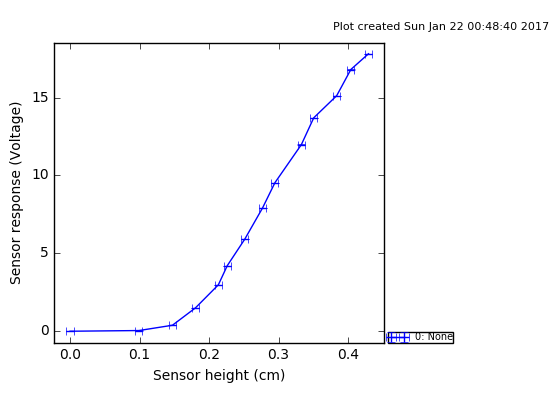

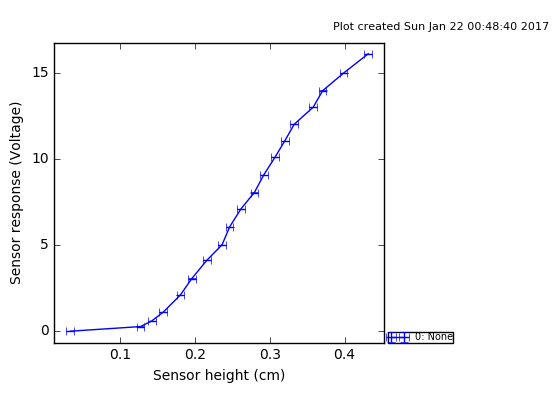

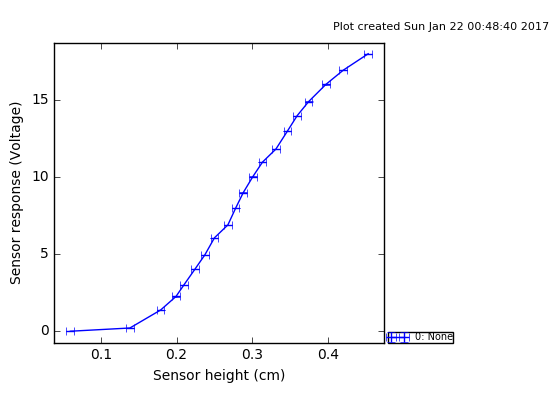

In [15]:
for i, calibration_data in enumerate(calibration_datas):
    fig = s.pylab.figure()
    ax = fig.add_axes([0,0,1,1])
    s.plot.xy.data(
        xdata=calibration_data[0], ydata=calibration_data[1],
        exdata=calibration_data[2], eydata=calibration_data[3],
        xlabel="Sensor height (cm)", ylabel="Sensor response (Voltage)")
    #s.pylab.savefig("calibration_curve"+str(i+1)+".pdf", bbox_inches='tight')

Try to overlap using polynomials:

Try to produce some linear fits:

In [61]:
def obtain_fit_results(calibration_data):
    chi_squares = []
    fits = []
    for start in range(0, 11):
        for length in range(3, len(calibration_data[0])-start):
            my_fitter = s.data.fitter(f='a*x + b', p='a, b')
            my_fitter._settings['autoplot'] = False
            length_of_regression = length
            start_of_regression = start
            end_of_regression = start_of_regression + length_of_regression
            my_fitter.set_data(
                xdata=calibration_data[0][start_of_regression:end_of_regression],
                ydata=calibration_data[1][start_of_regression:end_of_regression],
                exdata=calibration_data[2][start_of_regression:end_of_regression],
                eydata=calibration_data[3][start_of_regression:end_of_regression])
            my_fitter.fit()
            chi_squared = my_fitter.reduced_chi_squareds()[0]
            chi_squares.append([start, length, chi_squared])
            fits.append(my_fitter.results[0])
    return chi_squares, fits

In [62]:
all_fit_data = [obtain_fit_results(calibration_datas[i]) for i in range(3)]
chi_squares = [np.array(all_fit_data[i][0]) for i in range(3)]
best_fits = [np.argsort(np.abs(chi_squares[i][:, 2]-1)) for i in range(3)]
fit_params = [np.array(all_fit_data[i][1]) for i in range(3)]

In [95]:
for i in range(3):
    print("Curve", i)
    for j in range(10):
        print("Start, length, reduced chi-square:", fit_results[i][best_fits[i][j]])
        pass

Curve 0
Start, length, reduced chi-square: [   6.            3.          117.64611872]
Start, length, reduced chi-square: [   5.     3.   121.5]
Start, length, reduced chi-square: [   4.            4.          185.33898305]
Start, length, reduced chi-square: [   4.            5.          225.33697887]
Start, length, reduced chi-square: [   2.      3.    230.64]
Start, length, reduced chi-square: [   0.            3.          294.23518109]
Start, length, reduced chi-square: [   5.            4.          302.48170366]
Start, length, reduced chi-square: [   4.            7.          323.37672157]
Start, length, reduced chi-square: [   4.            6.          345.33029551]
Start, length, reduced chi-square: [   5.            5.          347.99141492]
Curve 1
Start, length, reduced chi-square: [ 10.           5.          20.96135609]
Start, length, reduced chi-square: [ 10.           4.          29.59417808]
Start, length, reduced chi-square: [  4.           3.          47.04054054]
Start

Try to increase a fake error to get realistic chi-squared values:

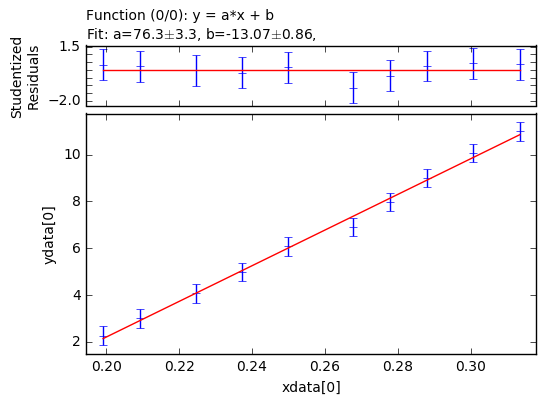

Weighted error: 0.387739518428
Chi^2: 0.264251709478


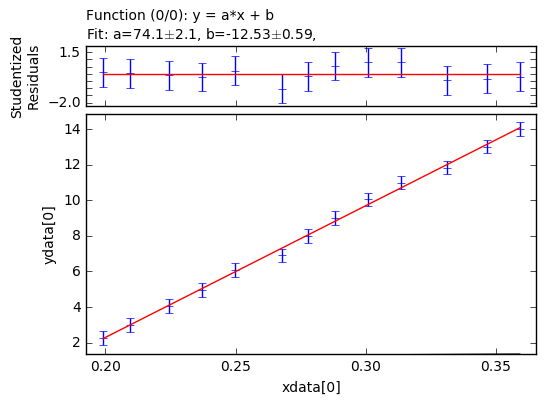

Weighted error: 0.376346224675
Chi^2: 0.287267207765


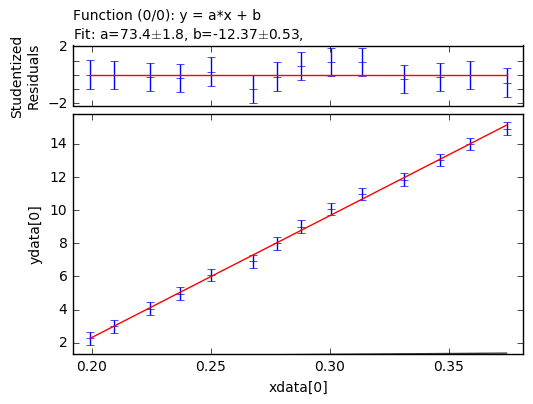

Weighted error: 0.373200353067
Chi^2: 0.30260874844


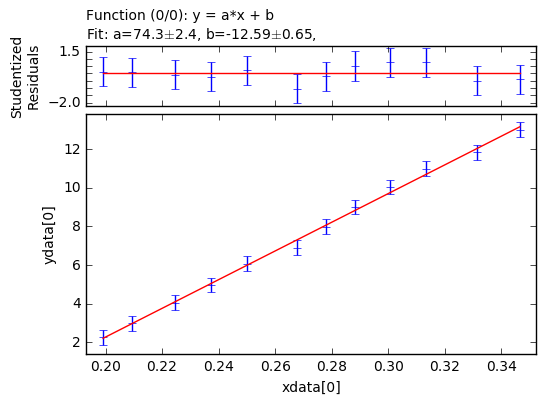

Weighted error: 0.377668612175
Chi^2: 0.308479946399


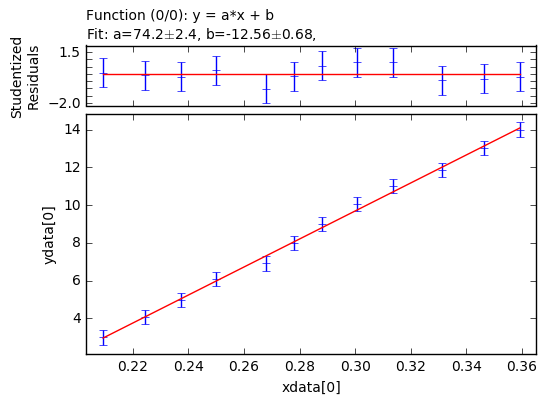

Weighted error: 0.376967193047
Chi^2: 0.313632313031


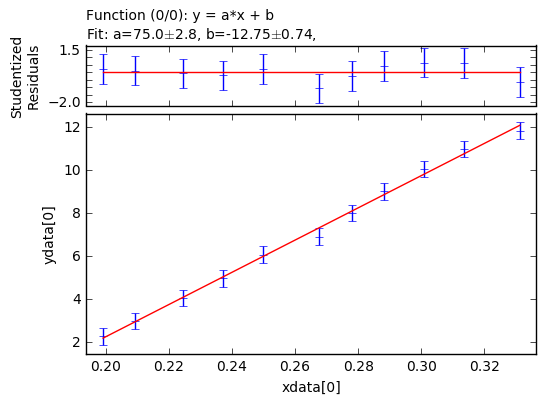

Weighted error: 0.381010792614
Chi^2: 0.312015686539


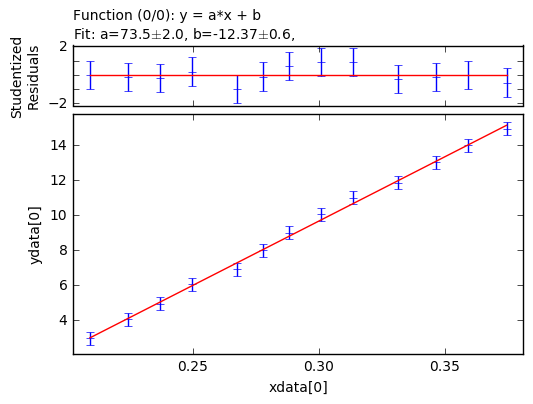

Weighted error: 0.373264326795
Chi^2: 0.329987327774


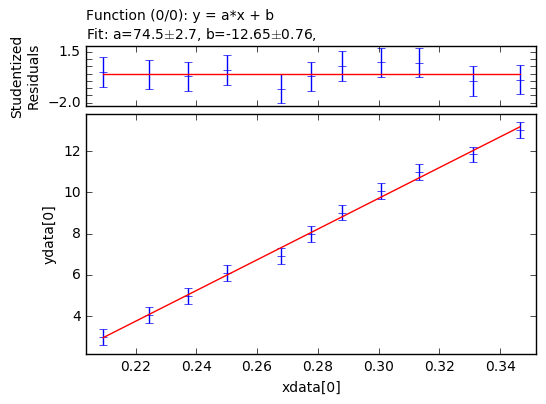

Weighted error: 0.378672490306
Chi^2: 0.338272548576


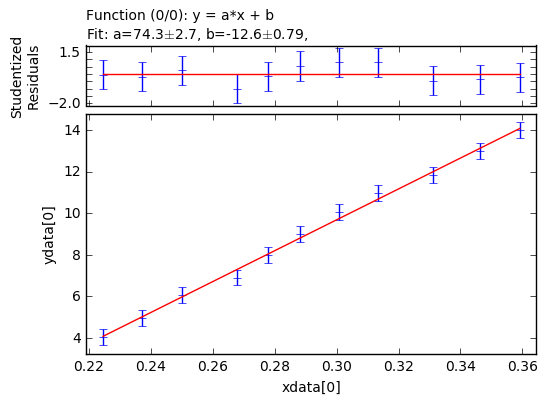

Weighted error: 0.377532330923
Chi^2: 0.346632426862


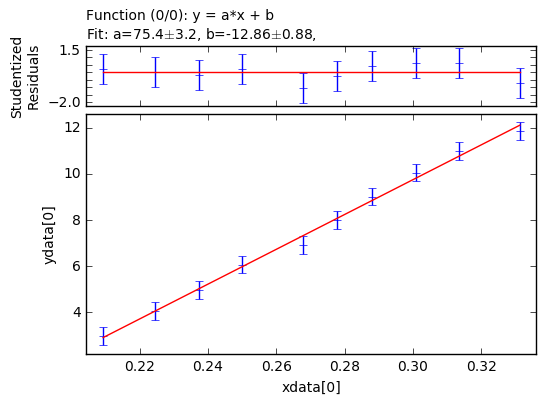

Weighted error: 0.382998488346
Chi^2: 0.339764376751


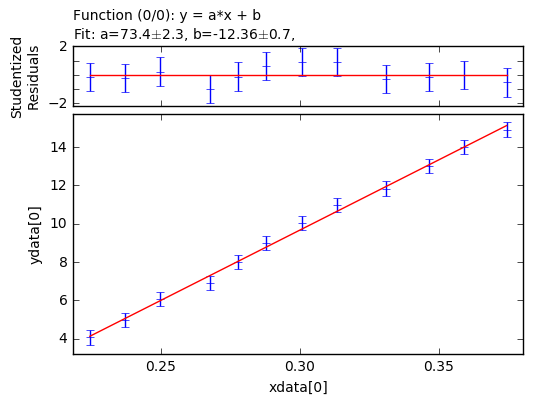

Weighted error: 0.373089470347
Chi^2: 0.363223525346


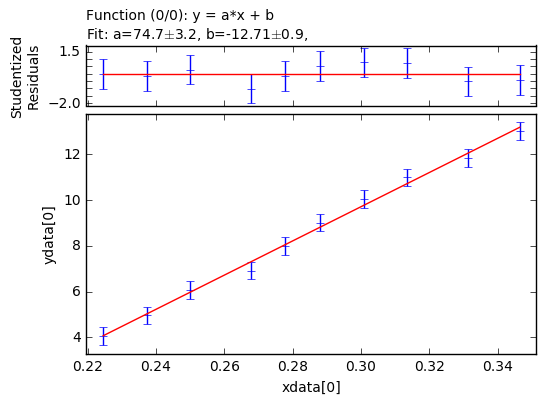

Weighted error: 0.379778752627
Chi^2: 0.376035154075


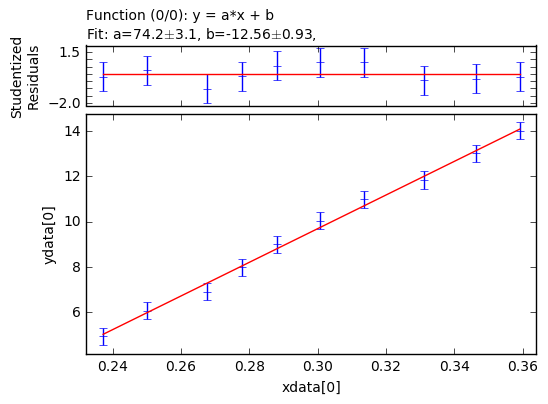

Weighted error: 0.376941217612
Chi^2: 0.390460197003


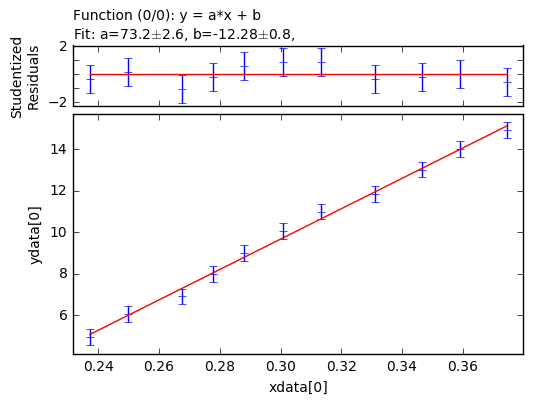

Weighted error: 0.371833752375
Chi^2: 0.401843757468


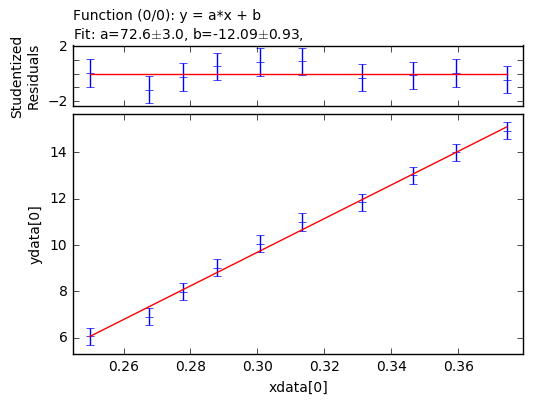

Weighted error: 0.368966489163
Chi^2: 0.440668300658


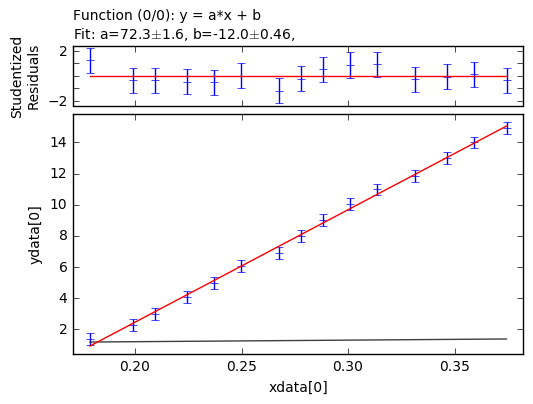

Weighted error: 0.367210687053
Chi^2: 0.450270563286


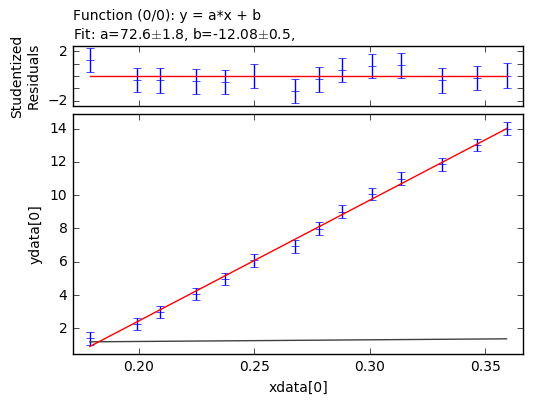

Weighted error: 0.368908585199
Chi^2: 0.46893279257


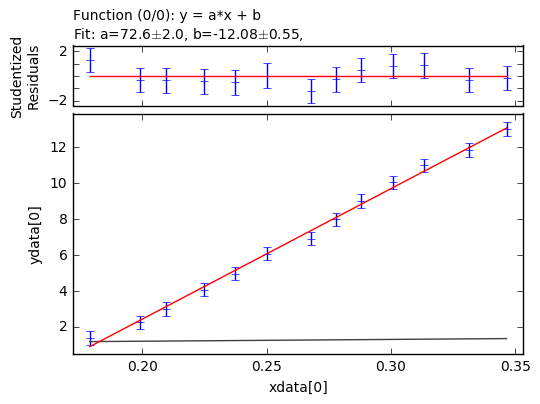

Weighted error: 0.368770379592
Chi^2: 0.511867652845


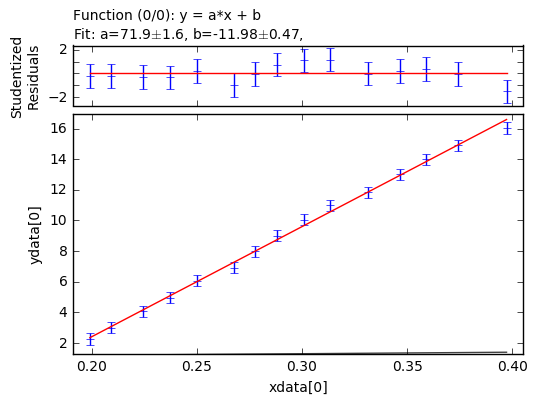

Weighted error: 0.36546839518
Chi^2: 0.535086211246


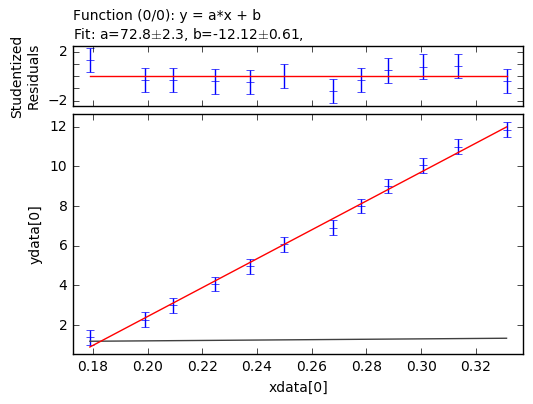

Weighted error: 0.369775303769
Chi^2: 0.55680877824


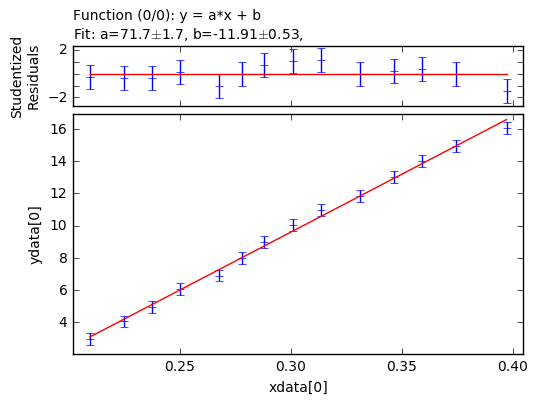

Weighted error: 0.364485443491
Chi^2: 0.576869933402


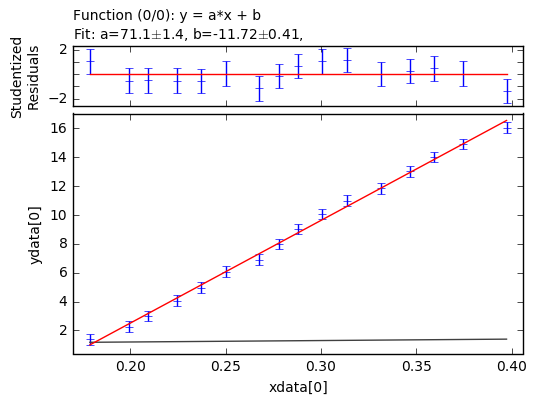

Weighted error: 0.361364129757
Chi^2: 0.611096818116


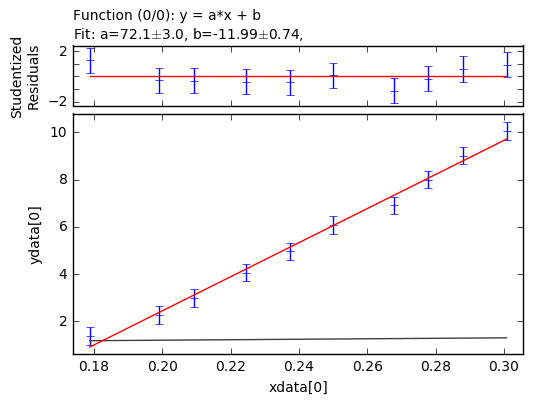

Weighted error: 0.366650092941
Chi^2: 0.595954629241


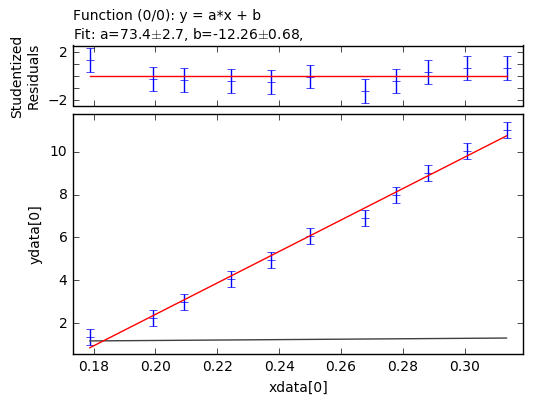

Weighted error: 0.372769228538
Chi^2: 0.586502146595


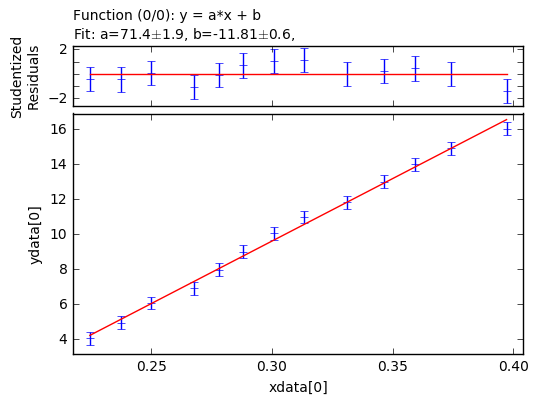

Weighted error: 0.362973329501
Chi^2: 0.623505067504


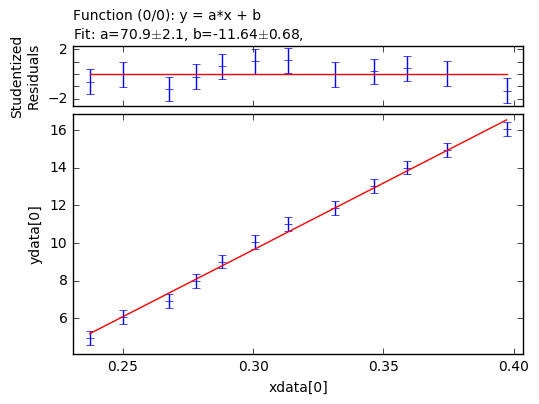

Weighted error: 0.3603777413
Chi^2: 0.667396969193


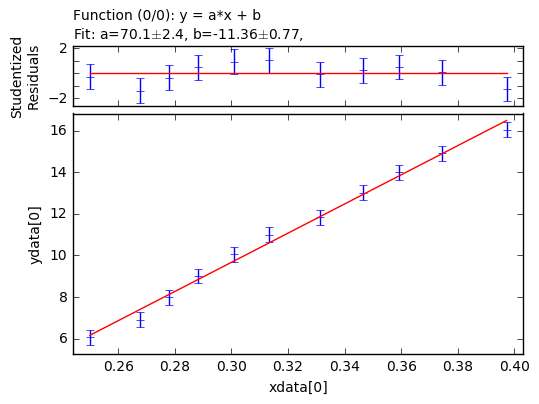

Weighted error: 0.356186853286
Chi^2: 0.697976502619


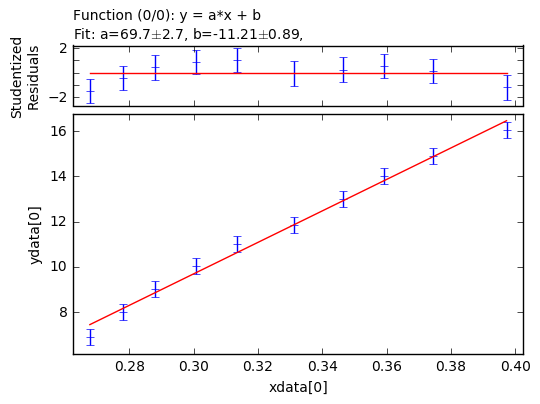

Weighted error: 0.354102170862
Chi^2: 0.782426573399


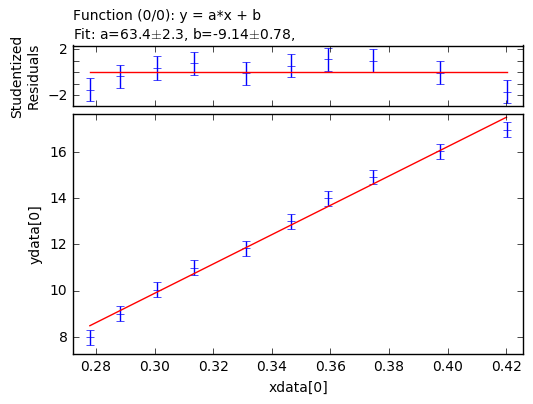

Weighted error: 0.32237934573
Chi^2: 1.073989343


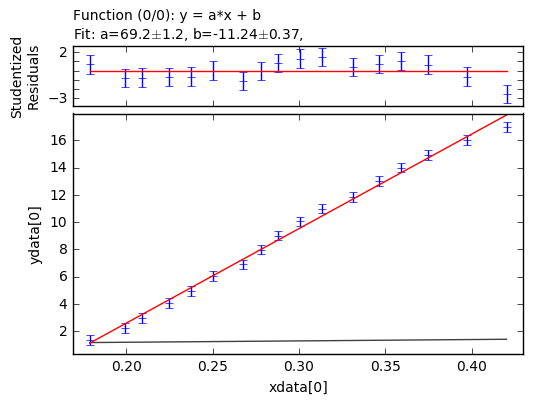

Weighted error: 0.351927237569
Chi^2: 1.1767163331


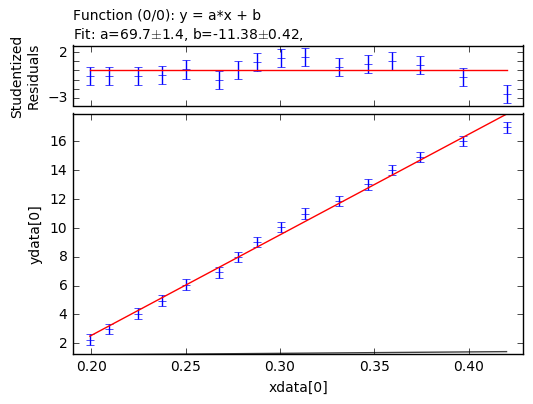

Weighted error: 0.354065230102
Chi^2: 1.20431189434


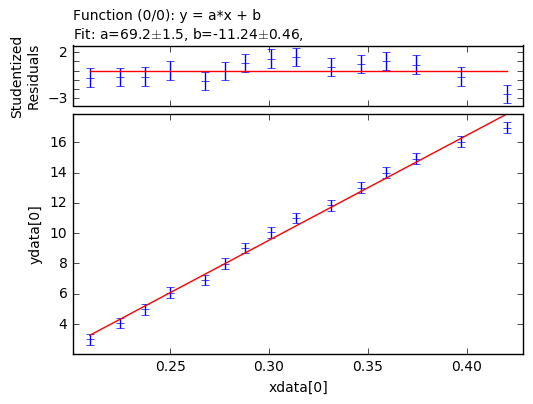

Weighted error: 0.351874649986
Chi^2: 1.27092990209


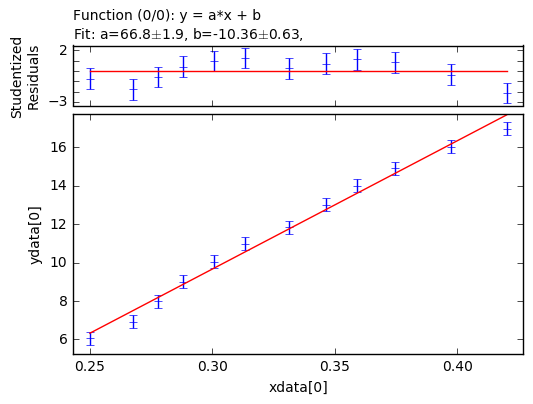

Weighted error: 0.339293083724
Chi^2: 1.40451483414


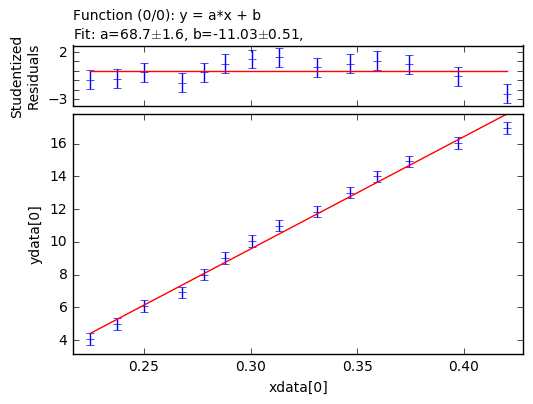

Weighted error: 0.348905213008
Chi^2: 1.33702369669


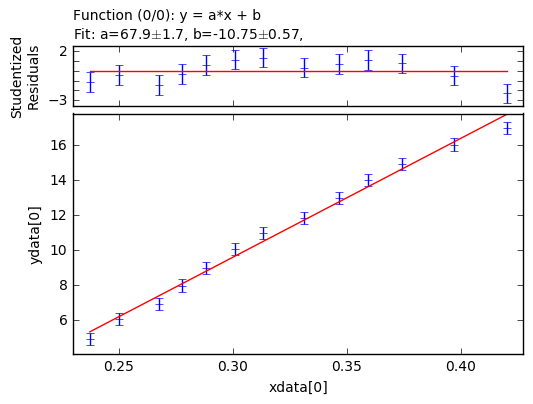

Weighted error: 0.344878877374
Chi^2: 1.38815494185


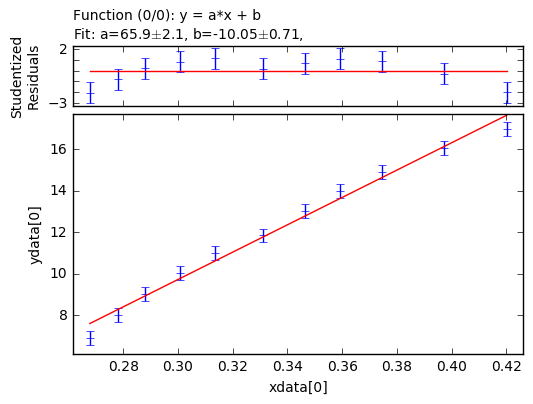

Weighted error: 0.334938892439
Chi^2: 1.5131115191


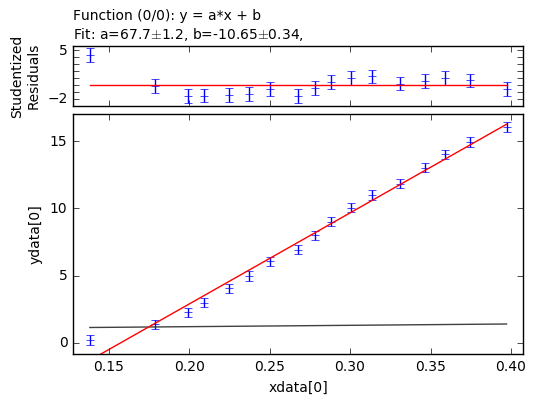

Weighted error: 0.344105036967
Chi^2: 2.40993662947


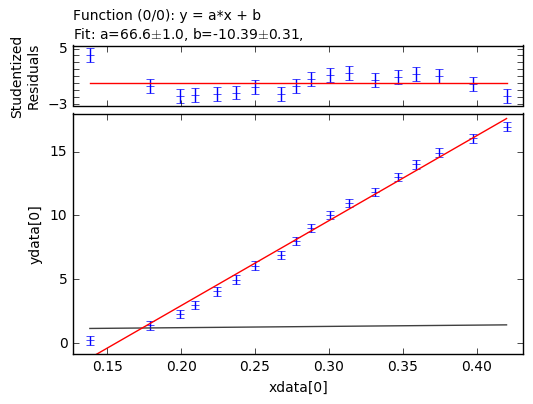

Weighted error: 0.338613747623
Chi^2: 2.62350256414


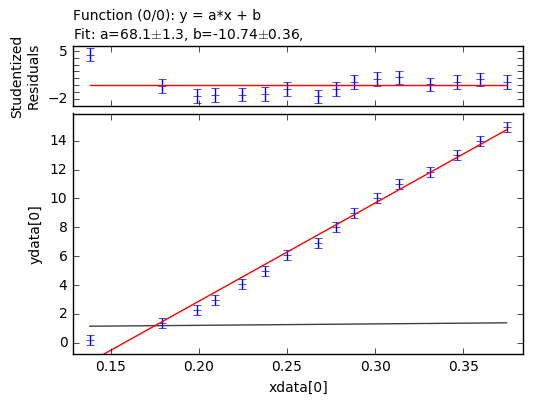

Weighted error: 0.346031794685
Chi^2: 2.52077844628


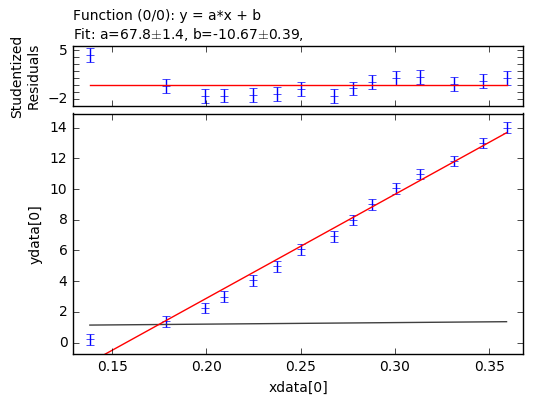

Weighted error: 0.344341553091
Chi^2: 2.71731067855


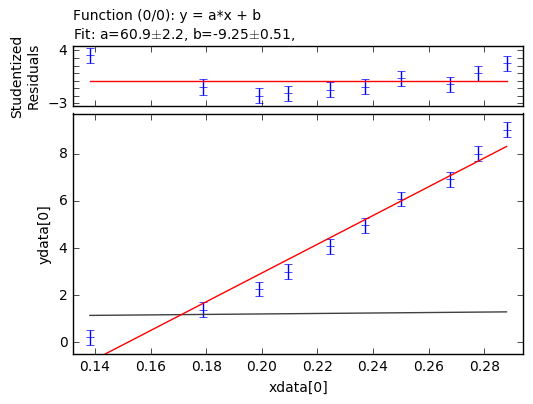

Weighted error: 0.309720777296
Chi^2: 3.43169970813


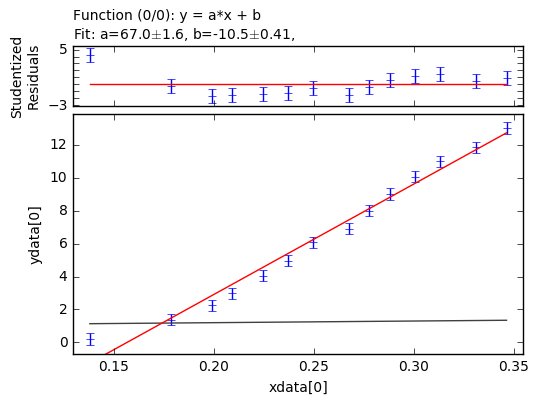

Weighted error: 0.340624933126
Chi^2: 2.9056522893


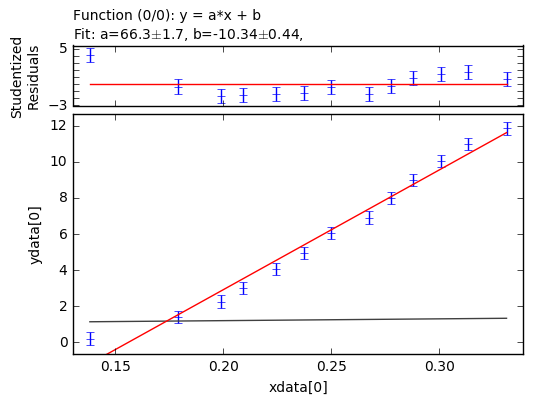

Weighted error: 0.33677695474
Chi^2: 3.15104744903


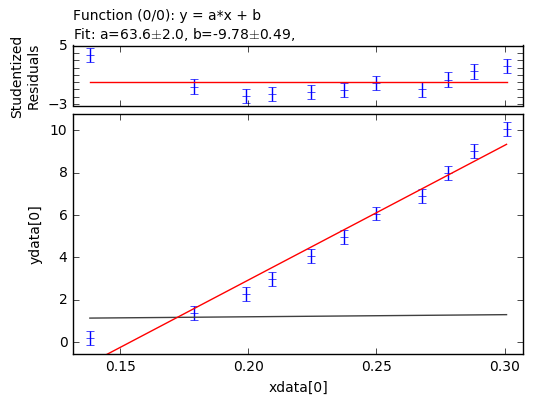

Weighted error: 0.323097937469
Chi^2: 3.54384711584


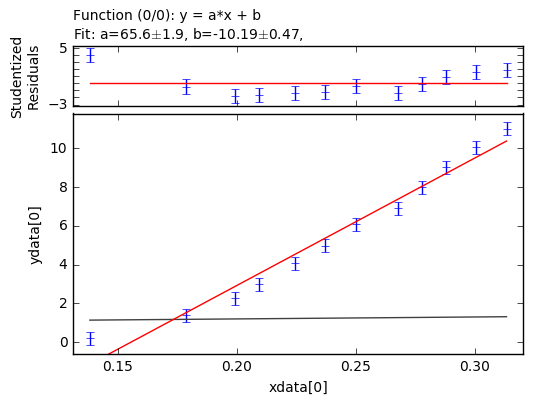

Weighted error: 0.333314332415
Chi^2: 3.47401549114


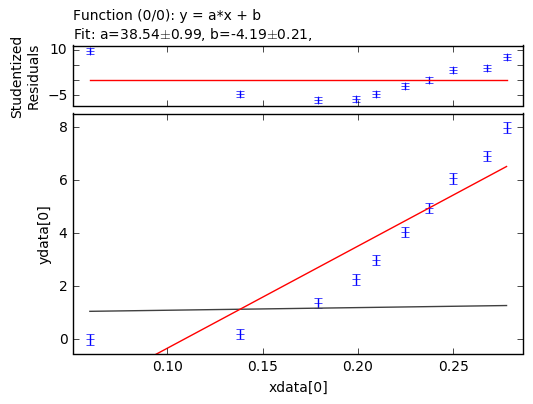

Weighted error: 0.196054404261
Chi^2: 38.4616111941


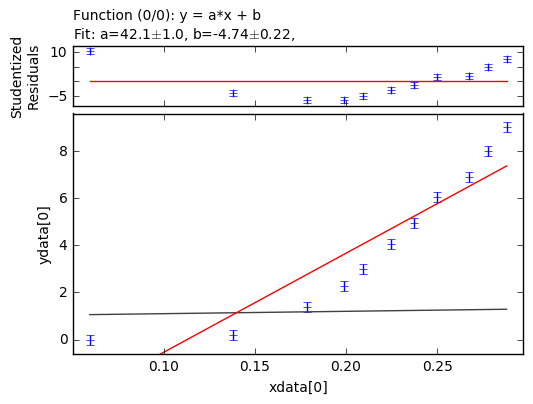

Weighted error: 0.213884197521
Chi^2: 37.0656491313


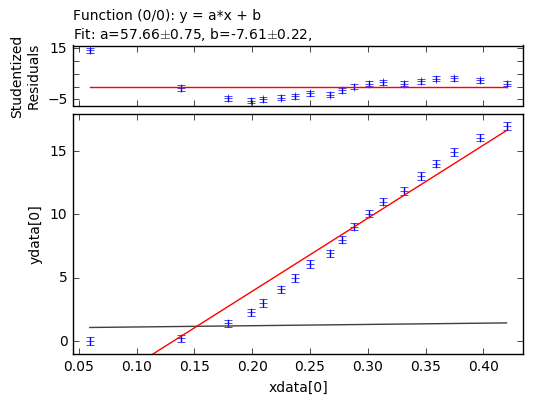

Weighted error: 0.293062051715
Chi^2: 21.7261492804


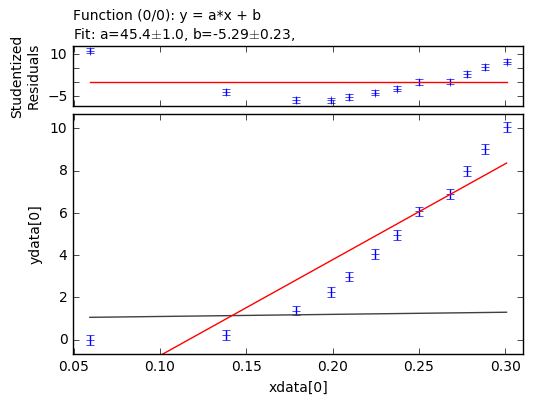

Weighted error: 0.230706997864
Chi^2: 35.4988765554


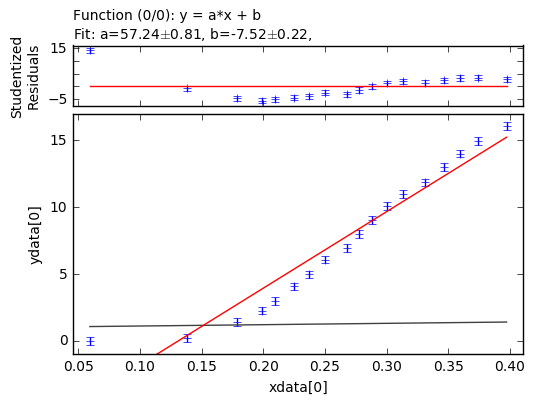

Weighted error: 0.290929834784
Chi^2: 23.3121192871


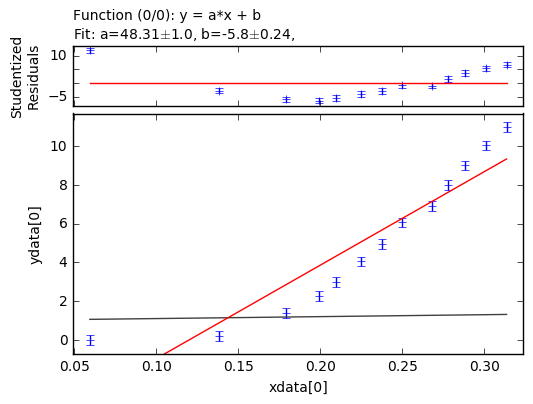

Weighted error: 0.24562769428
Chi^2: 33.5727990034


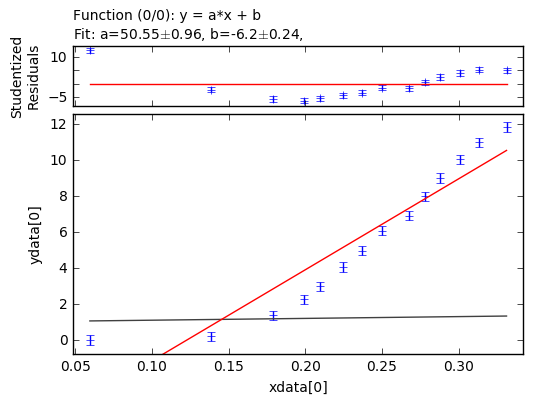

Weighted error: 0.256988638634
Chi^2: 30.8004277205


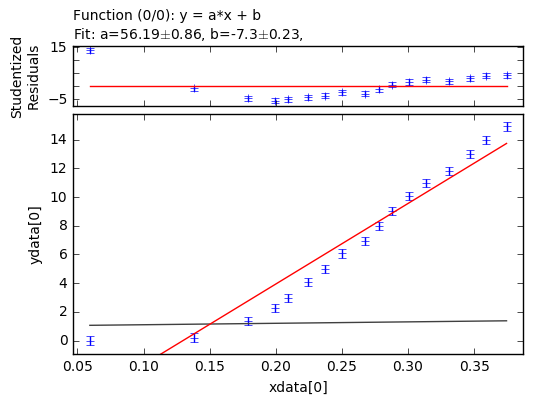

Weighted error: 0.285614503189
Chi^2: 25.1168486769


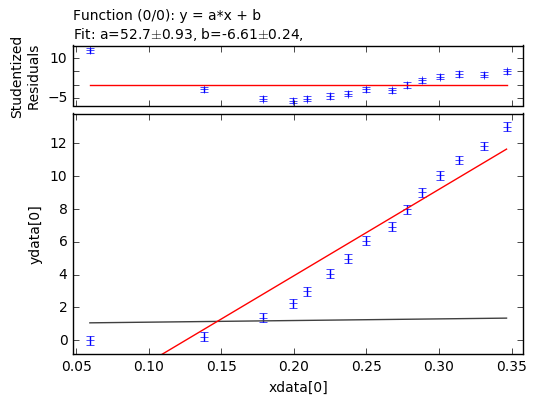

Weighted error: 0.267925773627
Chi^2: 28.6388260783


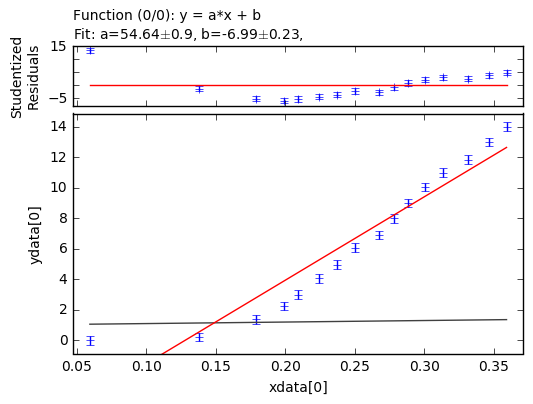

Weighted error: 0.277752826392
Chi^2: 26.8679506207


In [160]:
curve_number = 2
for i in range(len(best_fits[curve_number])):
    calibration_datas[curve_number][3][:] = 0.01
    current_slope = fit_params[curve_number][best_fits[curve_number][i]][0]
    
    #Add in errors from measurement
    temp_voltage_error = np.sqrt(
        np.square(calibration_datas[curve_number][3]) + \
        np.square(calibration_datas[curve_number][2]*current_slope))
    total_weighted_error = np.copy(temp_voltage_error)
    
    
    my_fitter = s.data.fitter(f='a*x + b', p='a, b')
    my_fitter._settings['autoplot'] = False
    length_of_regression = fit_results[curve_number][best_fits[curve_number][i]][1]
    start_of_regression = fit_results[curve_number][best_fits[curve_number][i]][0]
    end_of_regression = start_of_regression + length_of_regression
    
    my_fitter.set_data(
        xdata=calibration_datas[curve_number][0][start_of_regression:end_of_regression],
        ydata=calibration_datas[curve_number][1][start_of_regression:end_of_regression],
        exdata=calibration_datas[curve_number][2][start_of_regression:end_of_regression],
        eydata=total_weighted_error[start_of_regression:end_of_regression])

    if length_of_regression > 9:
        my_fitter.fit()
        my_fitter.plot()
        print("Weighted error:", total_weighted_error[0])
        print("Chi^2:", my_fitter.reduced_chi_squareds()[0])
    calibration_datas[curve_number][3][:] = 0.01

array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01])

In [162]:
np.sqrt(0.01**2 + 76.3**2*0.005**2)

0.38163103909404433